In [1]:
import matplotlib.pyplot as plt
import datetime
import numpy as np
import types
import pickle
import os
import glob
import rasterio
import obspy
from obspy.signal.cross_correlation import correlate, xcorr_max
from pyproj import Proj,transform,Geod
from scipy.signal import find_peaks,hilbert,butter,filtfilt
from scipy.fft import rfft,rfftfreq
from scipy.integrate import odeint
from seismic_analysis.preprocessing import download_data,remove_ir
from seismic_analysis.visualization import make_spectrogram
from seismic_analysis.attenuation import estimate_Q
from seismic_analysis.location import (compute_backazimuths,get_station_lon_lat,get_station_crs_locations,
                                get_station_grid_locations,load_data,get_grid,get_arrivals,get_velocities,
                                gridsearch,transform_imagery,plot_imagery_seismic_location)
from seismic_analysis.directivity import get_velocity, get_characteristic_frequency
from modeling.viscoelastic_beam import get_coefficients,asymptotic_solution,decay_comparison_plot
from modeling.fluid_fracture import find_min_rxx,model_fracture

In [3]:
'''

Display TerraSAR-X data from May 2012 to identify new rift and map fracture extent

'''

# load landsat images
landsat_scenes  = ['LE07_L2SR_233113_20120128_20200909_02_T2','LE07_L2SR_001113_20120204_20200909_02_T2']

# transform to convenient epsg:3245 coordinate system
# for landsat_scene in landsat_scenes:
#     file_path = 'data/LANDSAT/'+landsat_scene+'/'+landsat_scene + "_SR"
#     transform_imagery(file_path+'_B2.TIF','epsg:3245')
#     transform_imagery(file_path+'_B3.TIF','epsg:3245')
#     transform_imagery(file_path+'_B4.TIF','epsg:3245')

# set TerraSAR-X data file path
tsx_scenes = ['dims_op_oc_dfd2_690829826_1','dims_op_oc_dfd2_689344819_5']

# sort based on capture datetime
dates = []
for tsx_scene in tsx_scenes:
    file = os.listdir('data/TSX/' + tsx_scene + '/TSX-1.SAR.L1B/')[0]
    capture_string = '201205'+file.split('201205')[1].split('_')[0]
    capture_datetime = datetime.datetime.strptime(capture_string, "%Y%m%dT%H%M%S")
    dates.append(capture_datetime)
sort_idx = np.argsort(dates)
tsx_scenes = np.array(tsx_scenes)[sort_idx]

# transform to convenient epsg:3245 coordinate system
for tsx_scene in tsx_scenes:
    directory = os.listdir('data/TSX/' + tsx_scene + '/TSX-1.SAR.L1B/')[0]
    tsx_path = 'data/TSX/' + tsx_scene + '/TSX-1.SAR.L1B/' + directory + '/IMAGEDATA/'
    transform_imagery(glob.glob(tsx_path + '*.tif')[0],'epsg:3245')

# # make figure and axes
# fig, ax = plt.subplots(len(tsx_scenes),1,figsize=(10,10*len(tsx_scenes)),dpi=100)

# # iterate through tsx scenes
# for i in range(len(tsx_scenes)):
    
#     # overlay multiple landsat images
#     for j in range(len(landsat_scenes)):

#         # read each band
#         landsat_B2 = rasterio.open('data/LANDSAT/'+landsat_scenes[j]+'/'+landsat_scenes[j]+'_SR_B2_epsg:3245.TIF') #blue
#         landsat_B3 = rasterio.open('data/LANDSAT/'+landsat_scenes[j]+'/'+landsat_scenes[j]+'_SR_B3_epsg:3245.TIF') #green
#         landsat_B4 = rasterio.open('data/LANDSAT/'+landsat_scenes[j]+'/'+landsat_scenes[j]+'_SR_B4_epsg:3245.TIF') #red
#         image_B2 = landsat_B2.read(1)
#         image_B3 = landsat_B3.read(1)
#         image_B4 = landsat_B4.read(1)

#         # crop each band to 99th percentile of brightness
#         image_B2[image_B2 > np.percentile(image_B2,99)] = np.percentile(image_B2,99)
#         image_B3[image_B3 > np.percentile(image_B3,99)] = np.percentile(image_B3,99)
#         image_B4[image_B4 > np.percentile(image_B4,99)] = np.percentile(image_B4,99)

#         # combine bands into natural color image
#         image_rgb = np.array([image_B2, image_B3, image_B4]).transpose(1,2,0)
#         normalized_rgb = (image_rgb * (255 / np.max(image_rgb))).astype(np.uint8)

#         # get bounds
#         landsat_bounds = landsat_B2.bounds
#         horz_len = landsat_bounds[2]-landsat_bounds[0]
#         vert_len = landsat_bounds[3]-landsat_bounds[1]

#         # display image
#         if j == 0:
#             ax[i].imshow(normalized_rgb,extent=[landsat_bounds[0],landsat_bounds[2],landsat_bounds[1],landsat_bounds[3]],interpolation='none')
#         else:    
#             # add alpha channel to image so it can be overlayed
#             alpha_slice = np.array(normalized_rgb.shape)
#             alpha_slice[2] = 1
#             alpha_array = np.zeros(alpha_slice)
#             alpha_array[np.nonzero(image_B2)[0],np.nonzero(image_B2)[1],0] = 255
#             normalized_rgba = np.append(normalized_rgb,alpha_array,axis=2).astype(int)
#             ax[i].imshow(normalized_rgba,extent=[landsat_bounds[0],landsat_bounds[2],landsat_bounds[1],landsat_bounds[3]],interpolation='none')

#     # set overall plot bounds based on top landsat image
#     plot_bounds = [landsat_bounds[0]+0.425*horz_len,landsat_bounds[2]-0.35*horz_len,landsat_bounds[1]+0.3*vert_len,landsat_bounds[3]-0.475*vert_len]

#     # read each band
#     directory = os.listdir('data/TSX/'+ tsx_scenes[i] + '/TSX-1.SAR.L1B/')[0]
#     tsx_path = 'data/TSX/'+tsx_scenes[i]+'/TSX-1.SAR.L1B/'+ directory + '/IMAGEDATA/'
#     raster = rasterio.open(glob.glob(tsx_path + '*epsg:3245.tif')[0])
#     image = raster.read()

#     # crop each band to 99th percentile of brightness
#     image[image > np.percentile(image,99)] = np.percentile(image,99)

#     # plot TSX imagery
#     tsx_bounds = raster.bounds
#     horz_len = tsx_bounds[2]-tsx_bounds[0]
#     vert_len = tsx_bounds[3]-tsx_bounds[1]
#     masked_image = np.ma.masked_where(image[0] == 0, image[0])
#     ax[i].imshow(masked_image,extent=[tsx_bounds[0],tsx_bounds[2],tsx_bounds[1],tsx_bounds[3]],cmap='gray',vmin=75, vmax=400)

#     # set axis limits and turn off labels for scatter axis
#     ax[i].set_xlim([plot_bounds[0],plot_bounds[1]])
#     ax[i].set_ylim([plot_bounds[2],plot_bounds[3]])

# plt.show()

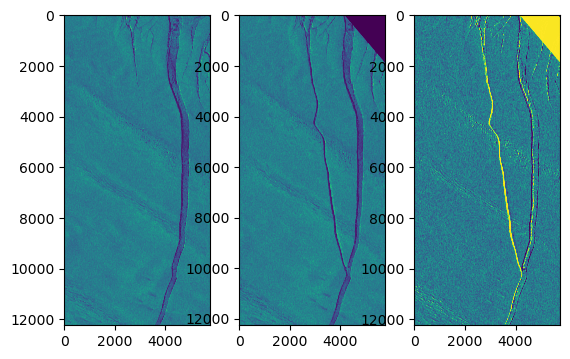

In [14]:
'''

Difference TerraSAR-X data from May 2012 to map fracture extent

'''

from rasterio.mask import mask
from shapely import geometry

# set TerraSAR-X data file path
tsx_scenes = ['dims_op_oc_dfd2_689344819_4','dims_op_oc_dfd2_689344819_5']

# iterate through tsx scenes
tsx_list = []
for i in range(len(tsx_scenes)):

    # read each band
    directory = os.listdir('data/TSX/'+ tsx_scenes[i] + '/TSX-1.SAR.L1B/')[0]
    tsx_path = 'data/TSX/'+tsx_scenes[i]+'/TSX-1.SAR.L1B/'+ directory + '/IMAGEDATA/'
    raster = rasterio.open(glob.glob(tsx_path + '*epsg:3245.tif')[0])

    # clip both images to same geographic extent 
    # raster.bounds returns left, bottom, right, top
    # below is left, right, bottom, top
    bounds = [-69720.89124696082, -60151.74121645112, 1722862.6392859274, 1743189.705003391]
    rift_mask = geometry.Polygon([(bounds[0],bounds[2]),
                            (bounds[0],bounds[3]),
                            (bounds[1],bounds[3]),
                            (bounds[1],bounds[2]),
                            (bounds[0],bounds[2])])
    image, out_transform = mask(raster, shapes=[rift_mask], crop=True)
    tsx_list.append(image)
    
#     image_gdf = gpd.GeoDataFrame(data=image,crs="EPSG:3245")
#     mask_gdf = gpd.GeoDataFrame(geometry=[pig_mask],crs="EPSG:3245")
#     pig_grounding_line = grounding_lines.clip(pig_gdf)

# difference images- NEED TO DEAL WITH GRID DISTANCE MORE INTELLIGENTLY. DOESN'T WORK AT ALL FOR SCAN IMAGE
diff = tsx_list[1][0,:tsx_list[0].shape[1],:tsx_list[0].shape[2]]-tsx_list[0][0]

fig,ax = plt.subplots(1,3)
for i in range(len(tsx_list)):
    image = tsx_list[i]
    image[image > np.percentile(image,99)] = np.percentile(image,99)
    ax[i].imshow(image[0,:,:])
ax[2].imshow(diff)
plt.show()

In [ ]:
'''

Download seismic data and remove instrumental response

'''

# download data for May 9 event
data_path = "data/"
starttime = obspy.UTCDateTime(2012, 5, 5)
endtime = obspy.UTCDateTime(2012, 5, 12)
networks = ["XC","YT"]
stations = ["PIG*","DNTW","UPTW","THUR","BEAR"]
channels = ["HH","BH"]
download_data(data_path,starttime,endtime,networks,stations,channels)

# dowload data for Scotia Sea earthquake
starttime = obspy.UTCDateTime(2013, 11, 17)
endtime = obspy.UTCDateTime(2013, 11, 18)
download_data(data_path,starttime,endtime,["XC"],["PIG2"],["HH"])

# remove instrumental response from data
output_type = 'VEL'
HH_freq_lims = [0.00005,0.0001,45,50]
BH_freq_lims = [0.00005,0.0001,15,20]
remove_ir(data_path,"HH",HH_freq_lims,output_type)
remove_ir(data_path,"BH",BH_freq_lims,output_type)

In [ ]:
'''

Plot time period between TerraSAR-X images

'''


In [ ]:
'''

Make spectrograms of May 9 event

'''

# read data
station = "PIG2"
channels = ["HHZ","HHN","HHE"]

# set parameters for spectrogram
starttime = obspy.UTCDateTime(2012,5,9,17,30)
endtime = obspy.UTCDateTime(2012,5,9,22)
low_freq = 0.0005
window_length = 50000
n_overlap = 20000

# make spectrogram of event
for channel in channels:
    st = obspy.read("data/MSEED/no_IR/" + station + "/" + channel + "/" + "2012-05-09*")
    make_spectrogram(st,starttime,endtime,low_freq,window_length,n_overlap)

In [ ]:
''' 

Compare spectra of May 9 event and Scotia plate teleseismic signal

'''

# set windows for both events and noise window before each event
rift_event_win = [obspy.UTCDateTime(2012, 5, 9, 18), obspy.UTCDateTime(2012, 5, 9, 19)]
rift_noise_win = [obspy.UTCDateTime(2012, 5, 9, 15), obspy.UTCDateTime(2012, 5, 9, 16)]
scotia_event_win = [obspy.UTCDateTime(2013, 11, 17, 9), obspy.UTCDateTime(2013, 11, 17, 10)]
scotia_noise_win = [obspy.UTCDateTime(2013, 11, 17, 8), obspy.UTCDateTime(2013, 11, 17, 9)]

In [ ]:
'''

Use BedMachine and David Shean's 2012 DEM of PIG to compute average ice and water thicknesses

'''

In [15]:
'''

Measure e-folding time and Q value from observations

'''

# set station and channel
station = "PIG2"
channel = "HHZ"

# read and process seismic data
st = obspy.read("data/MSEED/no_IR/" + station + "/" + channel + "/2012-05-09." + station + "." + channel + ".no_IR" + ".MSEED")

# set frequency bands (below values are log space)
#bands = [-3,-2.8,-1,0,1,2]
nyquist = np.log10(st[0].stats.sampling_rate/2)
freq_low = -3
num_steps = 35
step_size = (nyquist-freq_low)/num_steps
bands = [-3 + step_size*i for i in range(num_steps)]
if np.sum([bands == 0]) > 0: bands.remove(0)

# estimate Q in each frequency band
Q_vect = []
T_vect = []
for i in range(len(bands)-1):
    # estimate Q for current frequency band
    band = [10**bands[i],10**bands[i+1]]
    starttime = obspy.UTCDateTime(2012, 5, 9, 18)
    endtime = obspy.UTCDateTime(2012, 5, 9, 19,30)
    T,Q = estimate_Q(st.copy(),band,[starttime,endtime])
    Q_vect = np.append(Q_vect,Q)
    T_vect = np.append(T_vect,T)

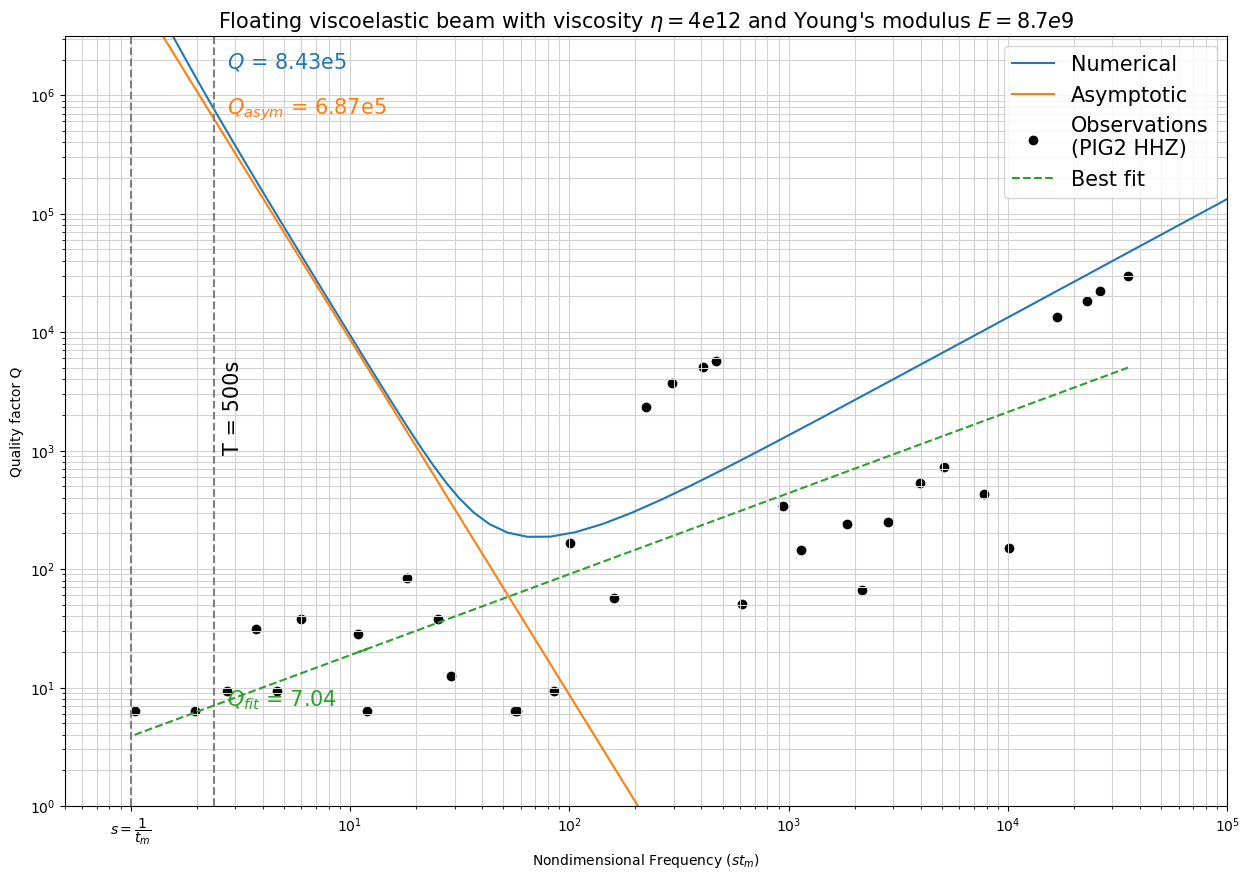

In [16]:
'''

Model viscoelastic beam to see whether viscous damping can explain observed ringdown time 

'''

# set ice shelf geometry (length is used to set lowest wavenumber)
H_i = 550
H_w = 700
L = 7e4

# define a range of wavenumbers
xi_vect = np.logspace(-5,np.log10(1000/H_i),100)

# define material properties
eta = 4e12
E = 8.7e9
nu = 0.3
mu = E/2/(1+nu)
t_m = eta/mu

# choose which physics to include
flexure = 1
water_waves = 1
inertia = 1
buoyancy = 1
physics = [flexure,water_waves,inertia,buoyancy]

# iterate through wavenumber vector and find roots
roots = []
for xi in xi_vect:
    coefficients = get_coefficients(H_i,H_w,xi/2/np.pi,eta,physics)
    roots.append(np.roots(coefficients))
roots = np.array(roots)

# get Taylor series approximations of the analytical expression for Q 
approximate_solutions = []
for xi in xi_vect:
    approximate_solutions.append(asymptotic_solution(xi,H_i,H_w,eta))
approximate_solutions = np.array(approximate_solutions)

# make plot comparing numerical Q and asymptotic approximation to Q
period_of_interest = 500
decay_comparison_plot(xi_vect,roots,approximate_solutions[:,3],T_vect,Q_vect,eta,E,period_of_interest)

In [ ]:
'''

Determine backazimuth of the event using polarization directions at local stations

'''

# initialize location parameter object and set parameters for backazimuth computation
l = types.SimpleNamespace()
l.win_len = 50
l.slide = 5
l.trace_len = 8*60
l.num_steps = int((l.trace_len-l.win_len)/l.slide)+1
l.stations = ["PIG2","PIG4","PIG5"]
l.network = ["XC"]

# specify path to data, XML, and output
l.data_path = "data/MSEED/no_IR"
l.xml_path = "data/XML"
l.filename = "outputs/locations/" + "_".join(l.stations) + "_backazimuth"
l.n_procs = 10

# set event start time
event_start = datetime.datetime(2012, 5, 9, 18, 1)
event_end = event_start + datetime.timedelta(seconds=l.trace_len)
l.detection_times = np.array([event_start])

# set the coordinate system in which we will do all grid-based calculations
l.crs = "EPSG:3245"

# set signal-to-noise ratio for throwing out stations and sta/lta ratio for throwing out individual windows in backazimuth computation
l.snr_threshold = 0
l.stalta_threshold = 0

# specify method for correcting pca components 
l.pca_correction = "distance"
l.centroid = "fixed"

# specify parameters for cross correlation based determination of station of first arrival
l.max_shift = 1000

# set frequency band for backazimuth calculation
l.fs = 100
l.freq = [1.5,5]

# calculate backazimuth for the event
b = compute_backazimuths(l)

In [ ]:
'''

Locate the event using travel time inversion of arrivals at regional stations

''' 
 
# read data
st = obspy.read("data/MSEED/no_IR/*/*/2012-05-09*")

# set frequency band for analysis
freq = [1.5,5]

# choose component to use for location
components = ["Z","N","E"]

# set starttime and endtime for analysis
starttime=obspy.UTCDateTime(2012,5,9,18,1)
endtime=obspy.UTCDateTime(2012,5,9,18,9)

# set on-ice phase velocity
local_velocity = 1500

# define grid origin in lat,lon and grid dimensions in meters
origin_lat_lon = [-75.5,-103.2]
grid_length = 1.5e5
grid_height = 1.3e5
step = 1000
t0 = -10
t_step = 0.1

# select, filter, and trim regional data
local_stations = ["PIG2","PIG4","PIG5"]
regional_stations = ["THUR","DNTW","BEAR","UPTW"]
st_local, st_regional = load_data(st,local_stations,regional_stations,components,freq,starttime,endtime)

# estimate phase velocity of waves from local reference station to regional stations
velocities = get_velocities("PIG2",st_local,local_stations,st_regional,regional_stations,components,local_velocity)

# combine into one stream and remove any stations, if desired
stations = local_stations + regional_stations
st = st_local + st_regional

# get arrival times relative to PIG2
arrivals, xcorr_coefs = get_arrivals("PIG2",st,stations,components)
#weights = np.abs(xcorr_coefs)

# set grid points and compute distance from grid origin to each station
x_vect,y_vect,t_vect = get_grid(grid_length,grid_height,step,t0,t_step)
station_lat_lon = np.fliplr(get_station_lon_lat("data/XML/",["XC","YT"],stations))
station_x_y = get_station_grid_locations(origin_lat_lon,station_lat_lon)

# carry out the gridsearch
rmse_mat = gridsearch(t_vect,x_vect,y_vect,station_x_y,velocities,arrivals)

# find lowest error lat, lon, and origin time
loc_idx = np.unravel_index(np.argmin(rmse_mat), rmse_mat.shape)
rmse_loc = rmse_mat[loc_idx[0],:,:]

# save error matrix
rmse_file = open("outputs/locations/" + "_".join(stations) + "_gridsearch.pickle", "wb")
pickle.dump(rmse_mat, rmse_file)
rmse_file.close()

In [ ]:
'''

Plot the backazimuthal and gridsearch locations on imagery

'''

# load background landsat images
landsat_scenes  = ['LE07_L2SR_233113_20120128_20200909_02_T2','LE07_L2SR_001113_20120204_20200909_02_T2']

# load TerraSAR-X data- first scene will be 'before' picture and second will be 'after'
tsx_scenes = ['dims_op_oc_dfd2_690829826_1','dims_op_oc_dfd2_689344819_5']

# set brightness for each TSX scene
vlims = np.array([[100,400], [30,285]])

# read seismic data
st = obspy.read("data/MSEED/no_IR/*/*/2012-05-**")
st = st.select(component="Z",station="PIG2")
st = st.filter('bandpass',freqmin=0.001,freqmax=0.1)
st = st.merge()

# load the results of polarization analysis
baz_file = open('outputs/locations/PIG2_PIG4_PIG5_backazimuth.pickle', "rb")
b = pickle.load(baz_file)
backazimuth = b.backazimuths
baz_file.close()

# load the results of polarization analysis
grid_file = open('outputs/locations/PIG2_PIG4_PIG5_THUR_DNTW_BEAR_UPTW_gridsearch.pickle', "rb")
rmse_mat = pickle.load(grid_file)
grid_file.close()
loc_idx = np.unravel_index(np.argmin(rmse_mat), rmse_mat.shape)
rmse_loc = rmse_mat[loc_idx[0],:,:]

# get local station locations and array centroids
station_lon_lat_coords = get_station_lon_lat("data/XML/",["XC"],["PIG2","PIG4","PIG5"])
station_grid_coords = get_station_crs_locations(station_lon_lat_coords,"epsg:3245")

# get gridsearch axes
origin_lat = -75.5
origin_lon = -103.2
grid_length = 1.5e5
grid_height = 1.3e5
step = 1000
x_vect = np.arange(0, grid_length, step)
y_vect = np.arange(0, grid_height, step)
p2 = Proj("EPSG:3245",preserve_units=False)
p1 = Proj(proj='latlong',preserve_units=False)
origin_x,origin_y = transform(p1,p2,origin_lon,origin_lat)
grid_axes_coords = [origin_x + x_vect, origin_y + y_vect]

# make plot of location
plot_imagery_seismic_location(landsat_scenes,tsx_scenes,st,backazimuth,rmse_loc,station_grid_coords,grid_axes_coords,vlims)

# Relating rupture speed to Doppler shift at two stations

\begin{align}
\text{In front of rift:} \hspace{0.5cm} f_{front} = f_f = \frac{c + v_o}{c - v_s} f\\
\text{Behind rift:} \hspace{0.5cm} f_{behind} = f_b = \frac{c + v_o}{c + v_s} f\\
\text{Observer velocity is zero:} \hspace{0.5cm} f_f = \frac{c}{c-v_s}f \hspace{0.5cm} \text{and} \hspace{0.5cm} f_b = \frac{c}{c+v_s}f\\
\frac{f_f}{f_b} = \left(\frac{c}{c-v_s}f\right) \div \left(\frac{c}{c+v_s}f\right)\\
\frac{f_f}{f_b} = \frac{c+v_s}{c-v_s}\\
f_f(c-v_s) = f_b(c+v_s)\\
f_fv-f_fv_s = f_bv+f_bv_s\\
f_fv - f_bv = f_fv_s+f_bv_s\\
c(f_f - f_b) = v_s(f_b+f_f)\\
v_s = c\frac{f_f-f_b}{f_f + f_b}\\
\end{align}

In [ ]:
'''

Estimate rift tip velocity using Doppler shift between DNTW and THUR

'''

# read data
st = obspy.read("data/MSEED/no_IR/*/*/2012-05-09*")

# set frequency band for analysis
freq = [1,5]

# set starttime and endtime for analysis
starttime=obspy.UTCDateTime(2012,5,9,18,2)
endtime=obspy.UTCDateTime(2012,5,9,18,8)

# select, filter, and trim regional data
regional_stations = ["DNTW","THUR"]
st_regional = obspy.Stream()
for stat in regional_stations:
    st_regional = st_regional.append(st.select(station=stat,channel="BHZ")[0])
st_regional.filter("bandpass",freqmin=freq[0],freqmax=freq[1])
st_regional.trim(starttime=starttime,endtime=endtime)

# select, filter, and trim local data
local_stations = "PIG2"
st_local = st.select(station=local_stations,channel="HHZ")
st_local.filter("bandpass",freqmin=freq[0],freqmax=freq[1])
st_local.trim(starttime=starttime,endtime=endtime)
st_local.resample(st_regional[0].stats.sampling_rate)
tr_local = st_local[0]

# estimate phase velocity of waves traveling from local to regional stations
velocities = []
for tr_regional in st_regional:
    velocities.append(get_velocity(tr_local,tr_regional))
mean_velocity = np.mean(velocities)

# get characteristic frequencies at each regional station
data_f = st.select(station="DNTW",channel="BHZ")[0].data
data_b = st.select(station="THUR",channel="BHZ")[0].data
f_f = get_characteristic_frequency(data_f,st[0].stats.sampling_rate,freq,"fft","median")
f_b = get_characteristic_frequency(data_b,st[0].stats.sampling_rate,freq,"fft","median")

# calculate rupture speed
v_s = (f_f-f_b)/(f_b+f_f)*mean_velocity

# estimate event duration
length = 7000
duration = length/v_s

# print results
print("Estimated rupture velocity: " + str(v_s) + " m/s")
print("Estimated duration: " + str(duration) + " s")

In [ ]:
'''

Model coupled fluid-fracture system to test whether fluid processes can explain slow rift tip velocity 

'''

H_i = 200
rho_i = 910
rho_w = 1000
H_w = rho_i/rho_w * H_i
g = 9.8
eta0 = H_w
d_eta_dt0 = 0
L0 = 5e3
w0 = 2
K_ic = 1e5
sigma0 = -rho_i*g*H_i/2 + rho_w*g/(2*H_i)*eta0**2
epsilon = 40

# The following calculates Rxx such that K_ic = K_i, and then adds a tiny perturbation
Rxx = find_min_rxx(L0,sigma0,K_ic)[0]+1

# run simulations
y0 = [eta0, d_eta_dt0,L0]
t = np.linspace(0, 400, 10001)
fig,ax=plt.subplots(3,1,figsize=(10,10),dpi=100)
fig.patch.set_facecolor('w')
sol = odeint(model_fracture, y0, t, args=(epsilon, H_i, Rxx, w0))

# plot solution
ax[0].plot(t, sol[:, 0]-H_w)
ax[0].set_ylabel('Deflection of water surface (m)')
ax[1].plot(t, np.gradient(sol[:, 2],t), label='L(t), km')
ax[1].set_ylabel('Crack propagation rate (m/s)')
ax[2].plot(t, sol[:, 2]/1e3, label='L(t), km')
ax[2].set_ylabel('Crack length (km)')
print("Mean crack propagation rate (epsilon="+str(epsilon)+"):",np.round(np.mean(np.gradient(sol[:, 2],t)),2)," m/s")
ax[0].grid()
ax[1].grid()
ax[2].grid()
plt.xlabel('Time (seconds)')
plt.show()